In [1]:
import os
import sys
import numpy as np
import sympy as sp

from pycalphad import Database, Model, calculate, variables as v
from fparser import *
from scipy.optimize import fsolve

import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution, minimize, curve_fit

from matplotlib.lines import Line2D
from matplotlib.text import Text
from matplotlib.legend_handler import HandlerLine2D
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

## Loading TDB file

In [3]:
db_filename = 'tdb_files/FeNi.TDB'

In [4]:
db = Database(db_filename)
available_phases = list(db.phases)
available_phases

['LIQUID',
 'B2_BCC',
 'BCC_A2',
 'COV3',
 'FCC_A1',
 'HCP_A3',
 'HIGH_SIGMA',
 'L12_FCC',
 'M3V',
 'NI2V',
 'NI2V7',
 'SIGMA']

In [5]:
phases = ['LIQUID','FCC_A1', 'BCC_A2']
components = ['FE', 'Ni', 'VA']

In [6]:
constituents = list(set([i for c in db.phases[phases[2]].constituents for i in c])) # Elements 
constituents

[Species('CO', 'CO1'),
 Species('FE', 'FE1'),
 Species('CR', 'CR1'),
 Species('NI', 'NI1'),
 Species('V', 'V1'),
 Species('VA', 'VA1')]

## Parsing TDB file Free Energy for MOOSE Framework

In [6]:
for phase in phases:
    print(f'  [F_{phase}]')
    print('    type = DerivativeParsedMaterial')

    
    constituents = list(set([i for c in db.phases[phase].constituents for i in c])) # Elements 
    constituents = ['FE', 'Ni', 'VA']
    
    # create thermodynamic model
    m = Model(db, constituents, phase)
    
    # export fparser expression
    # function_unparsed = m.ast
    # function_unparsed = m.ast.subs({'P':101325 , 'T':'temp', 
    #                                  'LIQUID0CO':'cA1',  'LIQUID0CR':'cB1', 'LIQUID0FE':'cC1', 'LIQUID0NI':'(1-cA1-cB1-cC1)', 
    #                                  'FCC_A10CO':'cA2',  'FCC_A10CR':'cB2', 'FCC_A10FE':'cC2', 'FCC_A10NI':'(1-cA2-cB2-cC2)',
    #                                  'FCC_A10V':0, 'LIQUID0V':0,
    #                                  'FCC_A11VA':1,
    #                                 })

    function_unparsed = m.ast.subs({'P':101325 , 'T':'temp', 
                                     'LIQUID0FE':'c1', 'LIQUID0NI':'(1-c1)', 
                                     'FCC_A10FE':'c2', 'FCC_A10NI':'(1-c2)',
                                     'BCC_A20FE':'c3', 'BCC_A20NI':'(1-c3)',
                                     'FCC_A11VA':1, 'BCC_A21VA':1
                                    })
    
    print(f"    expression = '{fparser(function_unparsed)}'" )
    
    print("    coupled_variables = '%s'" % " ".join([v.name for v in function_unparsed.free_symbols]))
    print('  []')

  [F_LIQUID]
    type = DerivativeParsedMaterial
    expression = '1.0*c1*(1 - c1)*(10180.0 - 4.146656*temp)*(2*c1 - 1) + 1.0*c1*(1 - c1)*(5.1622*temp - 16911.0) + 1.0*c1*(6.46677e-6*2.71828182845905^(0.0001135*temp + log(2.71828182845905^(0.8484467*log(3.24319969743e-9*temp + 1.00000050460842)) - 1.0) - 1.0*log(2.71569924e-14*temp + 4.22534787e-12)) + if(temp < 1811.0,-6.55843*temp - 3.6751551e-21*temp^7.0 + if(temp < 1811.0,77359.0*temp^(-1.0) - 23.5143*temp*log(temp) + 124.134*temp - 0.00439752*temp^2.0 - 5.8927e-8*temp^3.0 + 1225.7,2.29603e+31*temp^(-9.0) - 46.0*temp*log(temp) + 299.31255*temp - 25383.581) + 12040.17,-46.0*temp*log(temp) + 291.302*temp - 10838.83)) + 8.3145*temp*(1.0*if(c1 > 1.0e-15,c1*log(c1),0) + 1.0*if(c1 < 0.999999999999999,(1 - c1)*log(1 - c1),0)) + 1.0*(1 - c1)*if(temp < 1728.0,-9.397*temp - 3.82318e-21*temp^7.0 + if(temp < 1728.0,-22.096*temp*log(temp) + 117.854*temp - 0.0048407*temp^2.0 - 5179.159,1.12754e+31*temp^(-9.0) - 43.1*temp*log(temp) + 279.135*temp

## Plotting Free Energy From TDB expression

In [7]:
for i in range(3):
    constituents = ['FE', 'NI', 'VA'] # list(set([i for c in db.phases[phases[i]].constituents for i in c])) # Elements 
    m = Model(db, constituents, phases[i])
    if i == 0:
        G_LIQ = m.ast.subs({'T':'temp', 'LIQUID0FE':'c1', 'LIQUID0NI':'(1-c1)', 'FCC_A10FE':'c2', 'FCC_A10NI':'(1-c2)', 'BCC_A20FE':'c3', 'BCC_A20NI':'(1-c3)', 'FCC_A11VA':1, 'BCC_A21VA':1, 'P':101325})
    if i == 1:
        G_FCC = m.ast.subs({'T':'temp', 'LIQUID0FE':'c1', 'LIQUID0NI':'(1-c1)', 'FCC_A10FE':'c2', 'FCC_A10NI':'(1-c2)', 'BCC_A20FE':'c3', 'BCC_A20NI':'(1-c3)', 'FCC_A11VA':1, 'BCC_A21VA':1, 'P':101325})
    else:
        G_BCC = m.ast.subs({'T':'temp', 'LIQUID0FE':'c1', 'LIQUID0NI':'(1-c1)', 'FCC_A10FE':'c2', 'FCC_A10NI':'(1-c2)', 'BCC_A20FE':'c3', 'BCC_A20NI':'(1-c3)', 'FCC_A11VA':1, 'BCC_A21VA':1, 'P':101325})

In [8]:
def find_intersection(func1, func2, temp_range=(300, 2000), initial_guess=1000):
    def equation(temp):
        return func1(temp) - func2(temp)
    result = fsolve(equation, initial_guess)
    return result[0] if temp_range[0] <= result[0] <= temp_range[1] else None

In [9]:
c_Fe_LIQ = 0.9
c_Fe_FCC = 0.88
c_Fe_BCC = 0.96

LIQ_G = G_LIQ.subs({'c1':c_Fe_LIQ,})
FCC_G = G_FCC.subs({'c2':c_Fe_FCC,})
BCC_G = G_BCC.subs({'c3':c_Fe_BCC,})

temperature_subs_LIQ = sp.lambdify('temp', LIQ_G, modules="numpy")
temperature_subs_FCC = sp.lambdify('temp', FCC_G, modules="numpy")
temperature_subs_BCC = sp.lambdify('temp', BCC_G, modules="numpy")

temp_LIQ_TDB = np.linspace(300, 2000, 100)
temp_FCC_TDB = np.linspace(300, 2000, 100)
temp_BCC_TDB = np.linspace(300, 2000, 100)

F_LIQ_TDB = temperature_subs_LIQ(temp_LIQ_TDB)
F_FCC_TDB = temperature_subs_FCC(temp_FCC_TDB)
F_BCC_TDB = temperature_subs_BCC(temp_BCC_TDB)


Int_T_LIQ_FCC = find_intersection(temperature_subs_LIQ, temperature_subs_FCC)
Int_T_FCC_BCC = find_intersection(temperature_subs_FCC, temperature_subs_BCC)
Int_T_LIQ_BCC = find_intersection(temperature_subs_LIQ, temperature_subs_BCC)

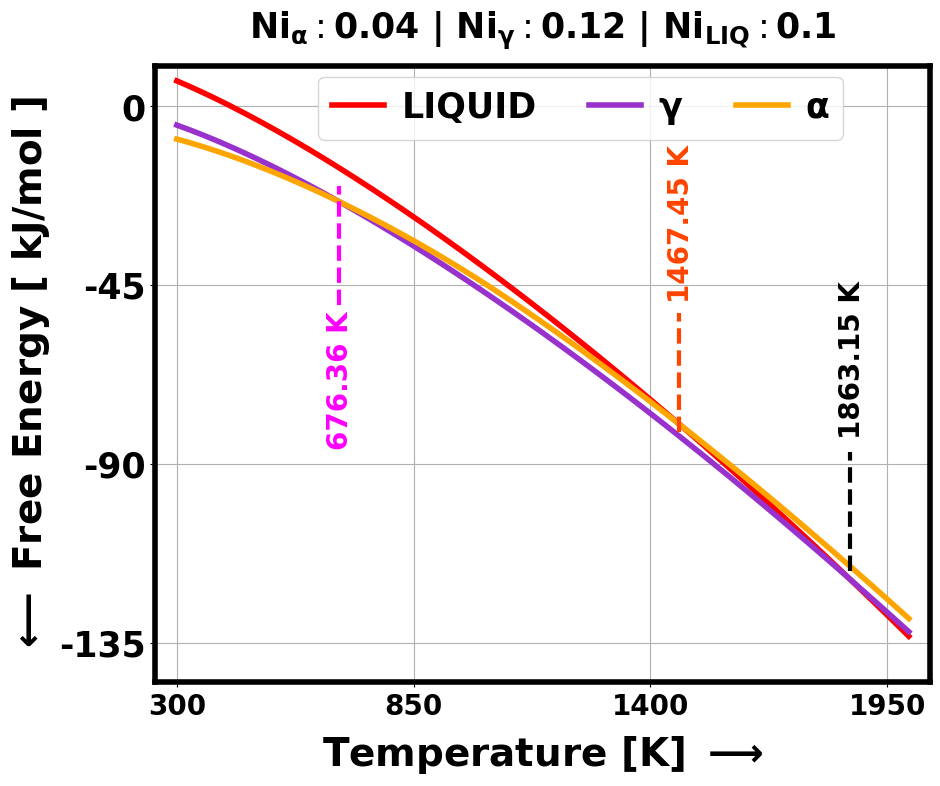

In [11]:
fig, ax1 = plt.subplots(1, 1, figsize=[10, 8], frameon=False)
ax1.set_facecolor((0, 0, 0, 0))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2)
ax1.plot(temp_LIQ_TDB, F_LIQ_TDB, c='r', lw=4, label='LIQUID')
ax1.plot(temp_FCC_TDB, F_FCC_TDB, c='darkorchid', lw=4, label=r'$\mathbf{\gamma}$')
ax1.plot(temp_BCC_TDB, F_BCC_TDB, c='orange', lw=4, label=r'$\mathbf{\alpha}$')

ax1.set_xlabel(r"Temperature [K] $\mathbf{\longrightarrow}$", weight = 'bold', size=28, color='k',  labelpad = 10)
ax1.set_ylabel(r"$\mathbf{\longleftarrow}$ Free Energy [ kJ/mol ]", weight = 'bold', size=28, color='k', labelpad=5)
ax1.get_yaxis().get_offset_text().set_position((-0.01, 0))

ax1.set_yticks([0, -45_000, -90_000, -135_000], labels=[ '0', '-45', '-90', '-135'], size=25, color='k', rotation=0,  weight='bold')
ax1.set_xticks([300, 850, 1400, 1950], labels=['300', '850', '1400', '1950', ], size=20, color='k', weight='bold',)

ax1.set_ylim(-145_000, 10_000)
ax1.set_xlim(250, 2050)

ax1.set_title(r"Ni$_\mathbf{\alpha}:\mathbf{0.04}$ | Ni$_\mathbf{\gamma}:\mathbf{0.12}$ | Ni$_\mathbf{LIQ}:\mathbf{0.1}$", weight='bold',pad=20, fontsize=25)

# ax1.legend(loc=(0.04,0.1), ncol=3,  columnspacing=1.5, prop={'weight':'bold', 'size':'25',},  handletextpad=0.5, handlelength=1.5,   frameon=True)#
ax1.legend(loc=(0.21,0.88), ncol=3,  columnspacing=1.5, prop={'weight':'bold', 'size':'25',},  handletextpad=0.5, handlelength=1.5,   frameon=True)#
ax1.spines[:].set_linewidth(4)
ax1.grid()

ax1.vlines(x=Int_T_FCC_BCC, ymin=-50000, ymax=-20000, linestyle='--', linewidth=3, color = 'magenta')
ax1.vlines(x=Int_T_LIQ_BCC, ymin=-82000, ymax=-52000, linestyle='--', linewidth=3, color = 'orangered')
ax1.vlines(x=Int_T_LIQ_FCC, ymin=-117000, ymax=-87000, linestyle='--', linewidth=3, color='black')

ax1.text(x=Int_T_FCC_BCC-30, y=-85000, s=f'{Int_T_FCC_BCC:.2f} K', weight='bold', rotation=90, fontsize=20, color='magenta')
ax1.text(x=Int_T_LIQ_BCC-28, y=-48000, s=f'{Int_T_LIQ_BCC:.2f} K', weight='bold', rotation=90, fontsize=20, color ='orangered')
ax1.text(x=Int_T_LIQ_FCC-28, y=-82000, s=f'{Int_T_LIQ_FCC:.2f} K', weight='bold', rotation=90, fontsize=20, color ='black')

# plt.savefig('free_energy.png',bbox_inches='tight', dpi=200)
plt.show()

In [277]:
T_B = 676
T_F =1863
T_LB = 1467
T_LF = 2000

F_B = temperature_subs_BCC(T_B)
F_F = temperature_subs_FCC(T_F)
F_LB = temperature_subs_LIQ(T_LB)
F_LF = temperature_subs_LIQ(T_LF)

F_B, F_F, F_LB, F_LF

(np.float64(-23977.351916143245),
 np.float64(-118992.67054300259),
 np.float64(-80023.23826503438),
 np.float64(-133383.24458087387))

In [16]:
c_Fe_values = np.arange(0.01, 0.99, 0.01)
temp = np.linspace(300, 2500, 100)

# Initialize arrays to store Gibbs free energy
F_LIQ_data = np.zeros((len(c_Fe_values), len(temp)))
F_FCC_data = np.zeros((len(c_Fe_values), len(temp)))
F_BCC_data = np.zeros((len(c_Fe_values), len(temp)))


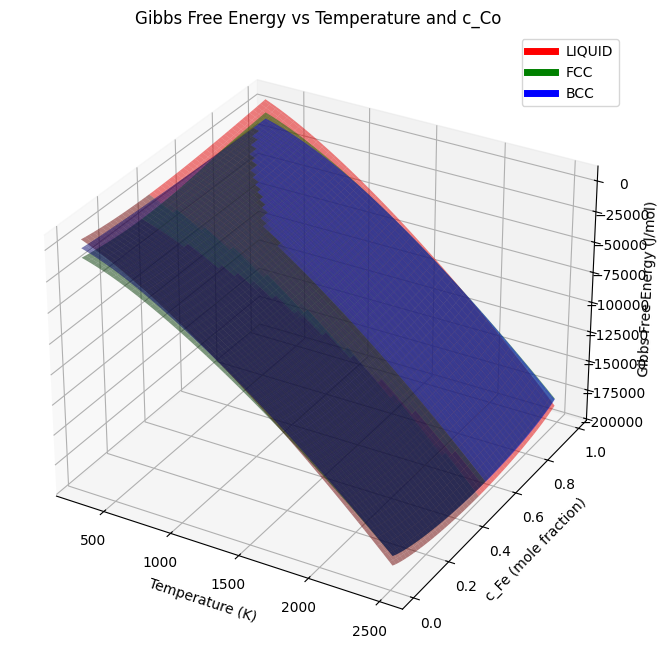

In [19]:
# Compute Gibbs free energy for each c_Co
for i, c_Fe in enumerate(c_Fe_values):
    c_Ni = 1 - c_Fe
    if c_Ni < 0:
        print(f"Warning: c_Ni = {c_Ni} is negative for c_Co = {c_Fe}. Skipping.")
        continue
    
    # Substitute compositions
    LIQ_G = G_LIQ.subs({'c1': c_Fe,})
    FCC_G = G_FCC.subs({'c2': c_Fe,})
    BCC_G = G_BCC.subs({'c3': c_Fe,})
    
    # Convert to callable functions
    temperature_subs_LIQ = sp.lambdify('temp', LIQ_G, modules="numpy")
    temperature_subs_FCC = sp.lambdify('temp', FCC_G, modules="numpy")
    temperature_subs_BCC = sp.lambdify('temp', BCC_G, modules="numpy")
    
    # Evaluate Gibbs free energy
    F_LIQ_data[i] = temperature_subs_LIQ(temp)
    F_FCC_data[i] = temperature_subs_FCC(temp)
    F_BCC_data[i] = temperature_subs_BCC(temp)

# Create 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Create mesh for c_Co and temperature
C_FE, TEMP = np.meshgrid(c_Fe_values, temp)

# Plot surfaces for LIQUID and FCC
ax.plot_surface(TEMP.T, C_FE.T, F_LIQ_data, color='red', alpha=0.5, label='LIQUID')
ax.plot_surface(TEMP.T, C_FE.T, F_FCC_data, color='green', alpha=0.5, label='FCC')
ax.plot_surface(TEMP.T, C_FE.T, F_BCC_data, color='blue', alpha=0.5, label='BCC')

# Set labels
ax.set_xlabel('Temperature (K)')
ax.set_ylabel('c_Fe (mole fraction)')
ax.set_zlabel('Gibbs Free Energy (J/mol)')

# Create custom legend
liquid_patch = Line2D([0], [0], color='red', lw=5, label='LIQUID')
fcc_patch = Line2D([0], [0], color='green', lw=5, label='FCC')
bcc_patch = Line2D([0], [0], color='blue', lw=5, label='BCC')
ax.legend(handles=[liquid_patch, fcc_patch, bcc_patch])

plt.title('Gibbs Free Energy vs Temperature and c_Co')
plt.show()

In [6]:
from io import StringIO
import pkgutil
import pandas as pd
from pymatgen.core import Element

def load_miedema_df():
    """Try to read Miedema.csv from the installed matminer package."""
    pkg = "matminer.utils.data_files"
    candidates = ["Miedema.csv", "miedema.csv", "Miedema.CSV"]
    for fname in candidates:
        data = pkgutil.get_data(pkg, fname)
        if data is not None:
            text = data.decode("utf-8", errors="ignore")
            return pd.read_csv(StringIO(text))
    # If pkgutil failed, try importlib.resources (py3.9+)
    try:
        from importlib.resources import files
        base = files(pkg)
        for fname in candidates:
            p = base.joinpath(fname)
            try:
                with p.open("r", encoding="utf-8", errors="ignore") as fh:
                    return pd.read_csv(fh)
            except FileNotFoundError:
                continue
    except Exception:
        pass
    raise FileNotFoundError("Could not find Miedema.csv inside matminer package. Is matminer installed?")

def get_element_molar_volume(symbol: str):
    """
    Return (molar_volume, column_name) for the given element symbol using matminer's Miedema table.
    Units: cm^3 / mol (the Miedema parameter 'molar_volume' is reported in cm^3/mol).
    """
    df = load_miedema_df()
    # Try to find the molar-volume column
    mv_cols = [c for c in df.columns if "molar" in c.lower() or "vmol" in c.lower() or "v_mol" in c.lower() or "v(" in c.lower()]
    if not mv_cols:
        # fallback: look for any numeric column with plausible element molar-volume magnitude
        numeric = df.select_dtypes("number")
        for c in numeric.columns:
            vals = numeric[c].dropna()
            if (vals > 0.1).all() and (vals < 200.0).all():  # reasonable cm^3/mol range for elements
                mv_cols.append(c)
                break
    if not mv_cols:
        raise ValueError(f"Couldn't detect a molar-volume column. Columns: {df.columns.tolist()}")
    mv_col = mv_cols[0]

    # find element column (symbol or name or Z)
    possible_elem_cols = [c for c in df.columns if any(k in c.lower() for k in ("symbol", "element", "el", "atom", "z", "atomic"))]
    elem_col = possible_elem_cols[0] if possible_elem_cols else df.columns[0]

    # try matching by symbol first
    sym = symbol.strip().capitalize()
    mask = df[elem_col].astype(str).str.strip().str.upper() == sym.upper()
    if not mask.any():
        # try match by atomic number
        try:
            z = Element(symbol).Z
            zcols = [c for c in df.columns if "z" == c.lower() or "atomic" in c.lower() and "number" in c.lower()]
            if zcols:
                mask = df[zcols[0]] == z
        except Exception:
            pass
    if not mask.any():
        # try case-insensitive contains
        mask = df[elem_col].astype(str).str.contains(symbol.strip(), case=False, na=False)

    if not mask.any():
        raise ValueError(f"Element '{symbol}' not found in Miedema data (checked column '{elem_col}').\nAvailable values sample: {df[elem_col].astype(str).unique()[:20]}")
    row = df[mask].iloc[0]
    mv_value = float(row[mv_col])
    return mv_value, mv_col

if __name__ == "__main__":
    mv, col = get_element_molar_volume("Fe")
    print(f"Element: Fe  —  {col} = {mv:.4f} cm^3/mol")


Element: Fe  —  molar_volume = 7.0900 cm^3/mol


## Free Energy

In [50]:
def Gibbs_LIQ(c_temp):
    c, T = c_temp
    F, A, c0, B, T0, D = 6983.4, 8545, 0.94, 0.00003, 1975, 20
    return F*(A*(c-c0)**2 + B*(T-T0)**2  - D)

def Gibbs_FCC(c_temp):
    c, T = c_temp
    F, A, c0, B, T0, D = 7932.8, 7125, 0.88, 0.00003, 1280.5, 15
    return F*(A*(c-c0)**2 + B*(T-T0)**2  - D)

def Gibbs_BCC(c_temp):
    c, T = c_temp
    F, A, c0, B, T0, D = 2397.7, 7560, 0.96, 0.00003, 881, 10
    return F*(A*(c - c0)**2 + B*(T - T0)**2 - D)

In [51]:
# Perform the optimization to find the minimum
LIQ_min = minimize(Gibbs_LIQ, x0=[0.96, 1863], method= 'Powell', bounds=[(0.8, 0.99), (1600, 2000)])
FCC_min = minimize(Gibbs_FCC, x0=[0.88, 1600], method= 'Powell', bounds=[(0.8,0.9), (300, 1500)])
BCC_min = minimize(Gibbs_BCC, x0=[0.92, 1200], method= 'Powell', bounds=[(0.9, 1.0), (300, 1000)])

# Extract the minimum x and y values
Lc_, LT_   = LIQ_min.x
Fc_, FT_   = FCC_min.x
Bc_, BT_   = BCC_min.x

# Get the minimum value of the function
F_min_LIQ = LIQ_min.fun
F_min_FCC = FCC_min.fun
F_min_BCC = BCC_min.fun

# Print the results
print(f'LIQ-BCC min = {F_min_LIQ:.1f}   |  |  (c1, temp) = {Lc_:.2f}, {LT_:.1f}')
print(f'FCC min     = {F_min_FCC:.1f}  |  |  (c3, temp) = {Fc_:.2f}, {FT_:.1f}')
print(f'BCC min     = {F_min_BCC:.1f}   |  |  (c4, temp) = {Bc_:.2f}, {BT_:.1f}')

LIQ-BCC min = -139668.0   |  |  (c1, temp) = 0.94, 1975.0
FCC min     = -118992.0  |  |  (c3, temp) = 0.88, 1280.5
BCC min     = -23977.0   |  |  (c4, temp) = 0.96, 881.0


/tmp/ipykernel_25852/3633737576.py:3: OptimizeWarning: Initial guess is not within the specified bounds
  FCC_min = minimize(Gibbs_FCC, x0=[0.88, 1600], method= 'Powell', bounds=[(0.8,0.9), (300, 1500)])
/tmp/ipykernel_25852/3633737576.py:4: OptimizeWarning: Initial guess is not within the specified bounds
  BCC_min = minimize(Gibbs_BCC, x0=[0.92, 1200], method= 'Powell', bounds=[(0.9, 1.0), (300, 1000)])


In [52]:
c = np.linspace(0.8, 1, 1000)
T = np.linspace(0, 2800, 1000)

# F_HCP = Gibbs_HCP(np.meshgrid(c, T))
F_LIQ = Gibbs_LIQ(np.meshgrid(c, T))
F_FCC = Gibbs_FCC(np.meshgrid(c, T))
F_BCC = Gibbs_BCC(np.meshgrid(c, T))

# Filter values to keep only negative ones
# G_HCP_neg = np.where(F_HCP < 0, F_HCP, np.nan)
G_LIQ_neg = np.where(F_LIQ < 0, F_LIQ, np.nan)
G_FCC_neg = np.where(F_FCC < 0, F_FCC, np.nan)
G_BCC_neg = np.where(F_BCC < 0, F_BCC, np.nan)


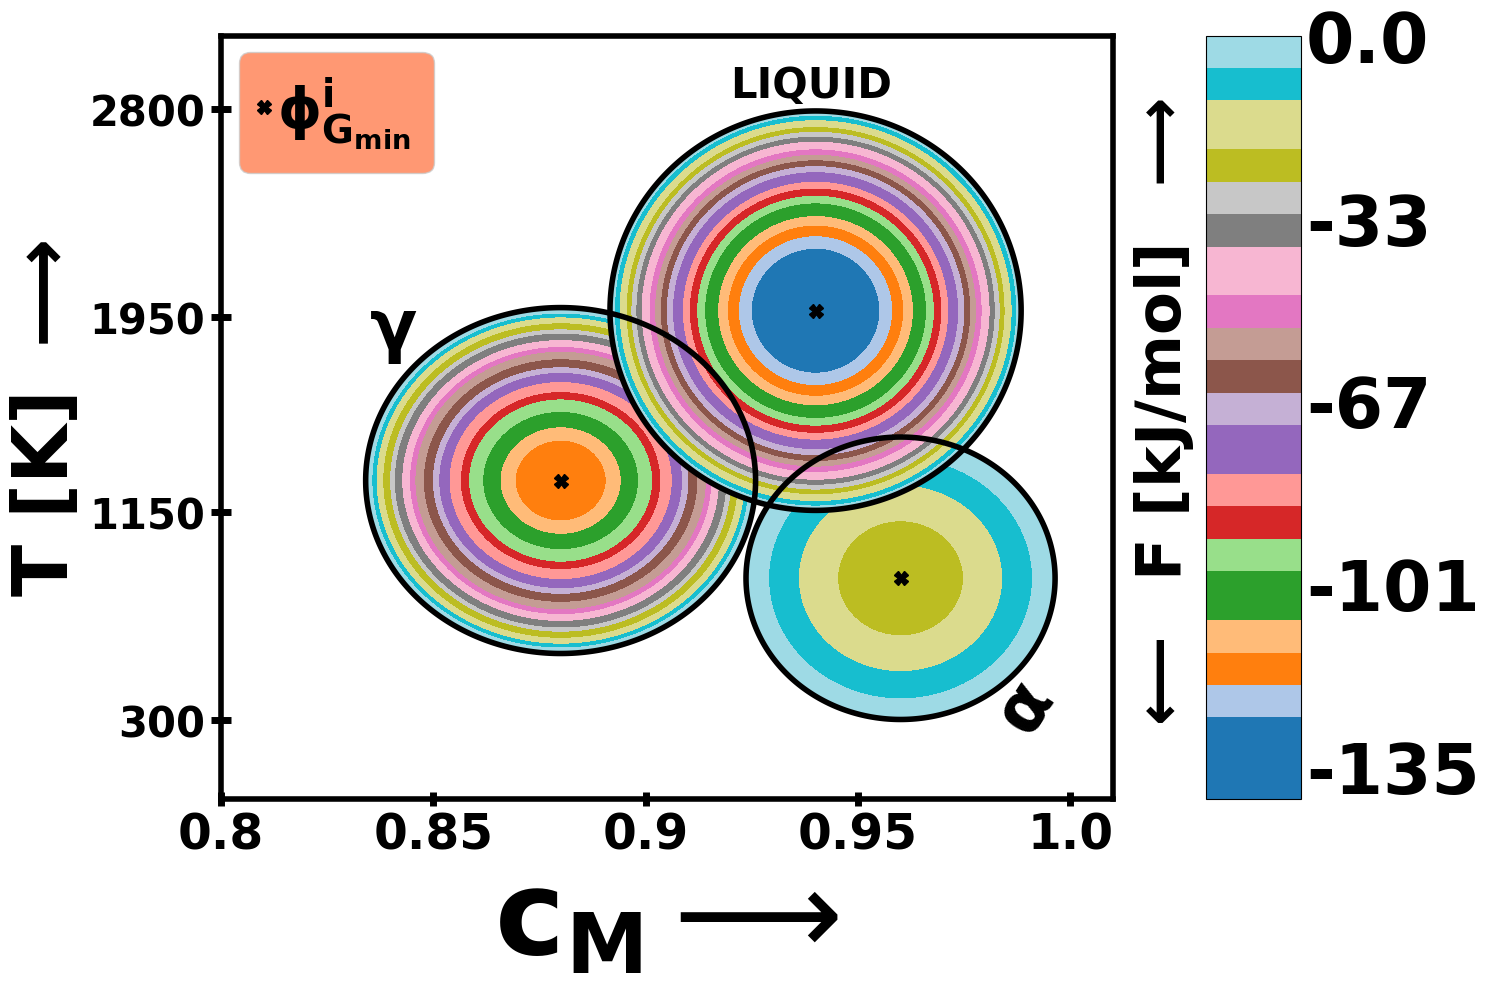

In [55]:
fig, ax1 = plt.subplots(1,1, figsize=(15,10), frameon=False)
ax1.set_facecolor((0, 0, 0, 0))

bcc_ = ax1.contourf(c, T, G_BCC_neg, cmap='tab20', vmin= -133231.9,   vmax=0, levels=50) # nipy_spectral_r
fcc_ = ax1.contourf(c, T, G_FCC_neg, cmap='tab20', vmin= -133231.9,  vmax=0, levels=50) # nipy_spectral_r
liq_ = ax1.contourf(c, T, G_LIQ_neg, cmap='tab20', vmin= -133231.9,  vmax=0, levels=50)

cbar = fig.colorbar(liq_, label='Gibbs  [J/mol]',aspect=8, pad=0.08)
cbar.ax.tick_params(labelsize=50, direction='inout', length=0, width=5)
cbar.set_ticks([-135000, -101250, -67500, -33750, 0],labels=['-135', '-101', '-67', '-33', '0.0',], weight='bold') 
cbar.set_label(r'$\mathbf{\longleftarrow}$  F [$\mathbf{kJ/mol}$]  $\mathbf{\longrightarrow}$', color='black', labelpad=-250, fontsize=45, rotation=90, weight='bold')

ax1.contour(c, T, F_LIQ, levels=[0], colors='black', linewidths=4)
ax1.contour(c, T, F_FCC, levels=[0], colors='black', linewidths=4)
ax1.contour(c, T, F_BCC, levels=[0], colors='black', linewidths=4)


ax1.plot(round(Lc_,4), round(LT_,1), marker='X', color='k', markersize=10, markeredgecolor='k', markerfacecolor='k', label=r'$\mathbf{\phi^i_{G_{min}}}$')
ax1.plot(round(Fc_,4), round(FT_,1), marker='X', color='k', markersize=10, markeredgecolor='k', markerfacecolor='k')
ax1.plot(round(Bc_,4), round(BT_,1), marker='X', color='k', markersize=10, markeredgecolor='k', markerfacecolor='k')
ax1.legend(loc=(0.02, 0.82), ncol=1,  columnspacing=1.0, prop={'weight':'bold', 'size':'40',}, 
           handletextpad=0.2, handlelength=0.1,   frameon=True).get_frame().set_facecolor('coral')

ax1.set_xlabel(r'c$\mathbf{_{M}} \longrightarrow$', weight='bold', fontsize=85)
ax1.set_ylabel('T [K] $\mathbf{\longrightarrow}$',  weight='bold', fontsize=55)
# ax1.tick_params(axis='both', labelcolor='black', labelsize=65, bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)

ax1.set_yticks([300, 1150, 1950, 2800], labels=['300', '1150', '1950', '2800'], size=30, color='k', weight='bold')
ax1.set_xticks([0.8, 0.85,  0.9, 0.95, 1.0], labels=['0.8', '0.85', '0.9', '0.95', '1.0'], size=35, color='k', weight='bold')
ax1.set_ylim(-20,3100)
ax1.set_xlim(0.8,1.01)

ax1.text(x=0.92, y = 2850, s=r'LIQUID', color='k', weight='bold', fontsize=30, rotation = 0)
ax1.text(x=0.835, y = 1820, s=r'$\mathbf{\gamma}$', color='k', weight='bold', fontsize=50, )
ax1.text(x=0.98, y = 250, s=r'$\mathbf{\alpha}$', color='k', weight='bold', fontsize=50, rotation=57)

ax1.tick_params(axis='y', direction='inout', which='both', length=15, width=5)
ax1.tick_params(axis='x', direction='inout', which='both', length=10, width=5)
ax1.spines[:].set_linewidth(4)

plt.tight_layout()

# plt.savefig('2D_FreeEnergy.jpg', bbox_inches='tight')
# plt.savefig('2D_FreeEnergy.png', bbox_inches='tight', dpi=800)

plt.show()